#1. Import Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from datetime import datetime
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC,SVC
import joblib
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore',category=ConvergenceWarning)

#2. Data Extraction

In [3]:
train_data=pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/train/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/test/test.csv')
train_data.shape,test_data.shape

((7352, 564), (2947, 564))

In [4]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


#3. Data Splitting

In [5]:
x_train=train_data.drop(['subject','Activity','ActivityName'],axis=1)
y_train=train_data['ActivityName']

x_test=test_data.drop(['subject','Activity','ActivityName'],axis=1)
y_test=test_data['ActivityName']
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [6]:
y_train.value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: ActivityName, dtype: int64

In [7]:
labels=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

#4. Build Functions

#4a Confusion Matxix Function

In [8]:
def plot_cm(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[1,j],fmt),horizontalalignment='center',
             color='white' if cm[i,j]>thresh else "black")
  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')

#4b Model Analysis Function

In [9]:
def model_Analysis(model,x_train,y_train,x_test,y_test,class_labels,cm_normalize=True,print_cm=True,cm_cmap=plt.cm.Greens):
  results=dict()
  print("Training the model")
  train_start_time=datetime.now()
  model.fit(x_train,y_train)
  print("Done")
  train_end_time=datetime.now()
  results['training_time']=train_end_time-train_start_time
  print('training time={}'.format(results['training_time']))

  print('Prediction Starts')
  prediction_start_time=datetime.now()
  y_pred=model.predict(x_test)
  prediction_end_time=datetime.now()
  print('Prediction ends')
  results['prediction_time']=prediction_end_time-prediction_start_time
  print('Prediction time={}'.format(results['prediction_time']))
  results['predicted']=y_pred


  accuracy=accuracy_score(y_test,y_pred)
  results['accuracy']=accuracy
  print('Accuracy of the model is={}'.format(accuracy))

  cm=confusion_matrix(y_test,y_pred)
  results['confusion_matrix']=cm
  if print_cm:
    print("**********Confusion Matrix***********")
    print(cm)
  plt.figure(figsize=(6,6))
  plt.grid(False)
  plot_cm(cm,classes=class_labels,normalize=True,title='Normalized Confusion Matrix',cmap=cm_cmap)
  plt.show()

  print("**********Classification Report**********")
  class_report=classification_report(y_test,y_pred)

  results['classification_report']=class_report
  print(class_report)

  results['model'] = model

  return results


#4c Tuned Hyperparameter Function

In [10]:
def print_grid_search_attributes(model):
  print('Best Estimator:{}'.format(model.best_estimator_))
  print('Best Parameter:{}'.format(model.best_params_))
  print('Total number of cross validation splits:{}'.format(model.n_splits_))
  print('Average crossvalidate score of best estimator:{}'.format(model.best_score_))

#5. Model Building

#5a Logistic Regression with hyperparameter tuning using Grid Search

In [13]:
x=pd.concat([x_train,x_test],axis=0)
y=pd.concat([y_train,y_test],axis=0)

Training the model
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Done
training time=0:00:19.334775
Prediction Starts
Prediction ends
Prediction time=0:00:00.026271
Accuracy of the model is=0.9582626399728538
**********Confusion Matrix***********
[[537   0   0   0   0   0]
 [  0 431  57   0   0   3]
 [  0  16 516   0   0   0]
 [  0   0   0 493   2   1]
 [  0   0   0   4 403  13]
 [  0   0   0  25   2 444]]


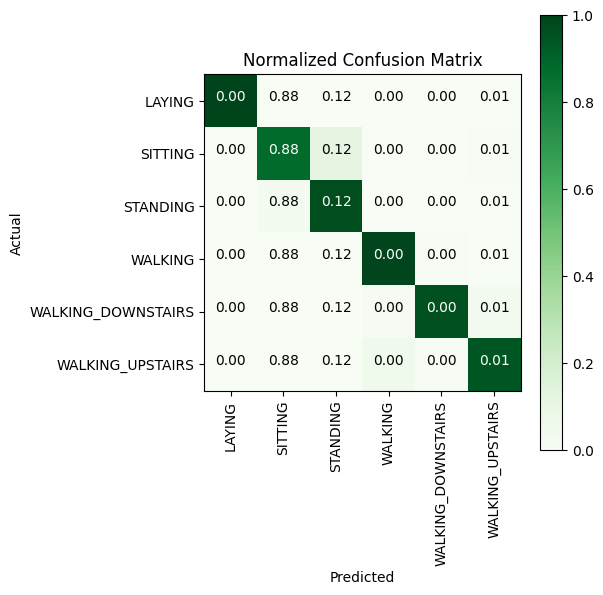

**********Classification Report**********
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mean Accuracy: 0.9824249211371342
Standard Deviati

In [14]:
params={'C':[0.01,0.1,1,10,20,30], 'penalty':['l2','l1']}
lr = LogisticRegression()
lr_grid=GridSearchCV(lr,param_grid=params,cv=3,verbose=1,n_jobs=-1)
lr_grid_results=model_Analysis(lr_grid,x_train,y_train,x_test,y_test,class_labels=labels)
#Cross Validation
outer_cv=KFold(n_splits=5,shuffle=True,random_state=42)
lr_nested_scores=cross_val_score(lr_grid,x,y,cv=outer_cv)
print("Mean Accuracy:",lr_nested_scores.mean())
print("Standard Deviation of Accuracy:",lr_nested_scores.std())
print_grid_search_attributes(lr_grid_results['model'])

#5b Decision Tree with hyperparameter tuning using Grid Search

Training the model
Done
training time=0:00:14.129653
Prediction Starts
Prediction ends
Prediction time=0:00:00.008179
Accuracy of the model is=0.8639294197488971
**********Confusion Matrix***********
[[537   0   0   0   0   0]
 [  0 385 106   0   0   0]
 [  0  93 439   0   0   0]
 [  0   0   0 471  17   8]
 [  0   0   0  14 345  61]
 [  0   0   0  73  29 369]]


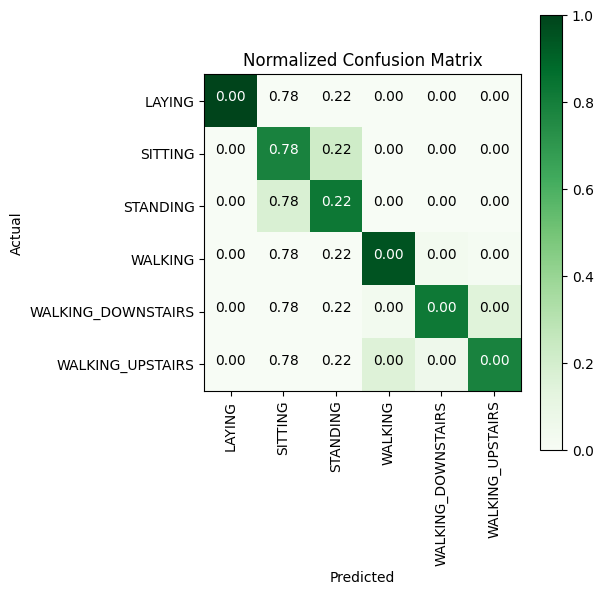

**********Classification Report**********
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.81      0.78      0.79       491
          STANDING       0.81      0.83      0.82       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.88      0.82      0.85       420
  WALKING_UPSTAIRS       0.84      0.78      0.81       471

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947

Mean Accuracy: 0.9206719729154976
Standard Deviation of Accuracy: 0.013447538874489462
Best Estimator:DecisionTreeClassifier(max_depth=7)
Best Parameter:{'max_depth': 7}
Total number of cross validation splits:3
Average crossvalidate score of best estimator:0.8443949852482812


In [15]:
params={'max_depth':np.arange(3,10,2)}
dt=DecisionTreeClassifier()
dt_grid=GridSearchCV(dt,params,n_jobs=-1,cv=3)
dt_grid_results=model_Analysis(dt_grid,x_train,y_train,x_test,y_test,class_labels=labels)
#Cross Validation
outer_cv=KFold(n_splits=5,shuffle=True,random_state=42)
dt_nested_scores=cross_val_score(dt_grid,x,y,cv=outer_cv)
print("Mean Accuracy:",dt_nested_scores.mean())
print("Standard Deviation of Accuracy:",dt_nested_scores.std())
print_grid_search_attributes(dt_grid_results['model'])

#5c Linear SVM with hyperparameter tuning using Grid Search

Training the model
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Done
training time=0:01:27.065504
Prediction Starts
Prediction ends
Prediction time=0:00:00.008573
Accuracy of the model is=0.9640312181879878
**********Confusion Matrix***********
[[537   0   0   0   0   0]
 [  2 419  65   0   0   5]
 [  0  10 521   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   2 413   5]
 [  0   0   0  15   1 455]]


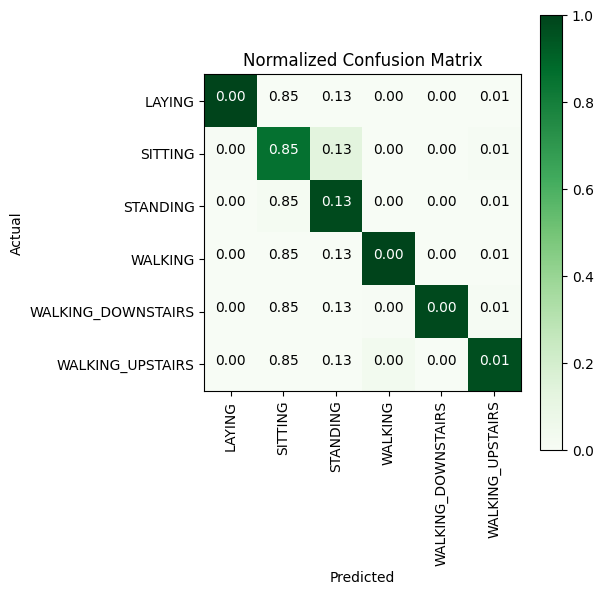

**********Classification Report**********
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.85      0.91       491
          STANDING       0.89      0.98      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.97      0.97       471

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.97      0.96      0.96      2947

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mean Accuracy: 0.9849498059667008
Standard Deviation of

In [16]:
parameters = {'C':[0.125, 0.5, 1, 2, 4, 8, 16]}
lr_svm = LinearSVC(tol=0.0005)
lr_svm_grid = GridSearchCV(lr_svm, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svm_grid_results = model_Analysis(lr_svm_grid, x_train, y_train, x_test, y_test, class_labels=labels)
#Cross Validation
outer_cv=KFold(n_splits=5,shuffle=True,random_state=42)
lr_svm_nested_scores=cross_val_score(lr_svm_grid,x,y,cv=outer_cv)
print("Mean Accuracy:",lr_svm_nested_scores.mean())
print("Standard Deviation of Accuracy:",lr_svm_nested_scores.std())
# observe the attributes of the model
print_grid_search_attributes(lr_svm_grid_results['model'])

#5d Radial basis function SVM using Grid Search CV

Training the model
Done
training time=0:04:20.842967
Prediction Starts
Prediction ends
Prediction time=0:00:00.925129
Accuracy of the model is=0.9626739056667798
**********Confusion Matrix***********
[[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


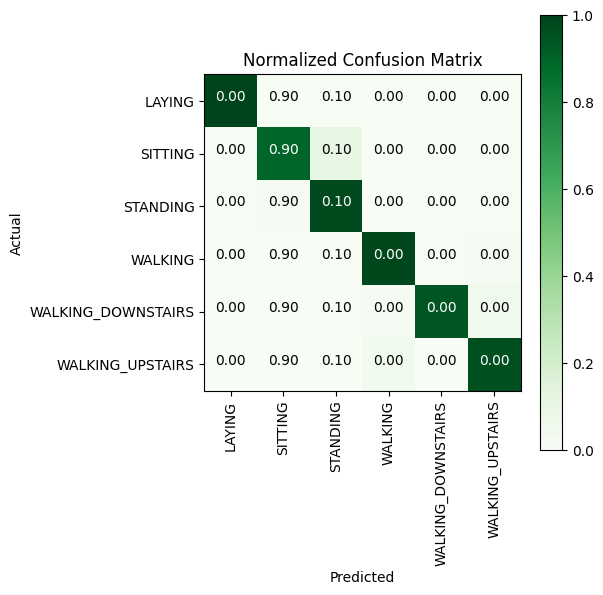

**********Classification Report**********
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Mean Accuracy: 0.9894162026056573
Standard Deviation of Accuracy: 0.0023274308617753222
Best Estimator:SVC(C=16, gamma=0.0078125)
Best Parameter:{'C': 16, 'gamma': 0.0078125}
Total number of cross validation splits:5
Average crossvalidate score of best estimator:0.9447834551903698


In [17]:
parameters = {'C':[2,8,16],'gamma': [ 0.0078125, 0.125, 2]}
rd_svm = SVC(kernel='rbf')
rd_svm_grid = GridSearchCV(rd_svm,param_grid=parameters, n_jobs=-1)
rd_svm_grid_results = model_Analysis(rd_svm_grid, x_train, y_train, x_test, y_test, class_labels=labels)
#Cross Validation
outer_cv=KFold(n_splits=5,shuffle=True,random_state=42)
rd_svm_nested_scores=cross_val_score(rd_svm_grid,x,y,cv=outer_cv)
print("Mean Accuracy:",rd_svm_nested_scores.mean())
print("Standard Deviation of Accuracy:",rd_svm_nested_scores.std())
# observe the attributes of the model
print_grid_search_attributes(rd_svm_grid_results['model'])

#5e Random Forest using Grid Search CV

Training the model
Done
training time=0:19:36.107062
Prediction Starts
Prediction ends
Prediction time=0:00:00.066922
Accuracy of the model is=0.9263657957244655
**********Confusion Matrix***********
[[537   0   0   0   0   0]
 [  0 431  60   0   0   0]
 [  0  37 495   0   0   0]
 [  0   0   0 482   7   7]
 [  0   0   0  26 352  42]
 [  0   0   0  32   6 433]]


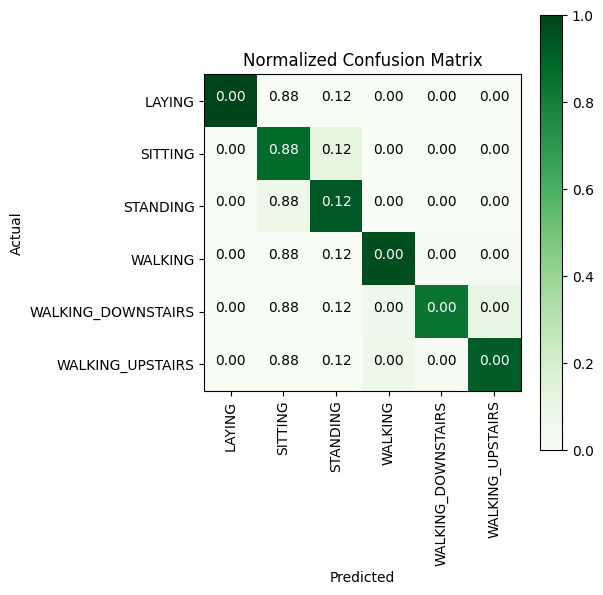

**********Classification Report**********
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.88      0.90       491
          STANDING       0.89      0.93      0.91       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.84      0.90       420
  WALKING_UPSTAIRS       0.90      0.92      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947

Best Estimator:RandomForestClassifier(max_depth=13, n_estimators=170)
Best Parameter:{'max_depth': 13, 'n_estimators': 170}
Total number of cross validation splits:5
Average crossvalidate score of best estimator:0.9211133154825492


In [11]:
params={'n_estimators':np.arange(10,201,20),'max_depth':np.arange(3,15,2)}
rf=RandomForestClassifier()
rf_grid=GridSearchCV(rf,params,n_jobs=-1)
rf_grid_results=model_Analysis(rf_grid,x_train,y_train,x_test,y_test,class_labels=labels)
#Cross Validation
#outer_cv=KFold(n_splits=5,shuffle=True,random_state=42)
#rf_nested_scores=cross_val_score(rf_grid,x,y,cv=outer_cv)
#print("Mean Accuracy:",rf_nested_scores.mean())
#print("Standard Deviation of Accuracy:",rf_nested_scores.std())
print_grid_search_attributes(rf_grid_results['model'])

#6. Models Comparision

In [18]:
print('Models                       Accuracy     Crossvalidation Accuracy     Error')
print('Logistic Regression:         {:.04}%      lr_nested_scores.mean()      {:.04}%'.format(lr_grid_results['accuracy']*100,100-(lr_grid_results['accuracy']*100)))
print('Decision Tree Classifier:    {:.04}%      dt_nested_scores.mean()      {:.04}%'.format(dt_grid_results['accuracy']*100,100-(dt_grid_results['accuracy']*100)))
print('Random Forest Classifier:    {:.04}%                               {:.04}%'.format(rf_grid_results['accuracy']*100,100-(rf_grid_results['accuracy']*100)))
print('Linear SVM:                  {:.04}%      lr_svm_nested_scores.mean()  {:.04}%'.format(lr_svm_grid_results['accuracy']*100,100-(lr_svm_grid_results['accuracy']*100)))
print('Radial SVM:                  {:.04}%      rd_svm_nested_scores.mean()  {:.04}%'.format(rd_svm_grid_results['accuracy']*100,100-(rd_svm_grid_results['accuracy']*100)))

Models                       Accuracy     Crossvalidation Accuracy     Error
Logistic Regression:         95.83%      lr_nested_scores.mean()      4.174%
Decision Tree Classifier:    86.39%      dt_nested_scores.mean()      13.61%
Random Forest Classifier:    92.64%                               7.363%
Linear SVM:                  96.4%      lr_svm_nested_scores.mean()  3.597%
Radial SVM:                  96.27%      rd_svm_nested_scores.mean()  3.733%


#7. Conclusion

After compairing all the models, clear winner is linear SVM or Radial Basis Function SVM with accuracy more than 96%.

In [19]:
joblib.dump(lr_svm_grid_results['model'],'LinearSVM.pkl')

['LinearSVM.pkl']